On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.tree import DecisionTreeRegressor

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [5]:
%run Regression_GAM_Gamma.py

# Val croisée

In [6]:
n_knots = 10

In [7]:
for curr_depth in tqdm(range(1,51)):
    cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})
    
    cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        
        curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
        for code in liste_stations_debit:
            curr_train_X_mean[code] = 0
        curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
        curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
        curr_train_X_standard["Date"] = curr_train_X["Date"]
        #GAM
        spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
        curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                               curr_train_X_standard, 
                                                                               liste_stations_debit)
        model_tree = DecisionTreeRegressor(max_depth=curr_depth)
        model_tree.fit(X = curr_train_X_standard[colonnes_meteo_stations],
                  y = curr_train_X_standard_residus[liste_stations_debit])
        
        # Predictions Standard
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                              curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
        curr_test_X_standard["Date"] = curr_test_X["Date"].values
        predictions_test_Y_standard_residus = model_tree.predict(curr_test_X_standard[colonnes_meteo_stations])
        predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
        predictions_test_Y_standard_residus["Date"] = curr_test_X_standard["Date"].values
        # Filtre sur les dates
        resultat = pd.DataFrame()
        for curr_date in liste_dates:
            resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
        resultat = resultat.sort_values(by = "Date")
        predictions_test_Y_standard_residus = resultat.copy()
        # On rajoute la compo saisonnalité
        predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
        predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
        for code in liste_stations_debit:
            predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values
        
        # Score standard
        curr_test_Y_standard = fct_Standardize(curr_test_Y, 
                                               curr_train_X_mean, curr_train_X_std, 
                                               liste_stations_debit)
        curr_test_Y_standard["Date"] = curr_test_Y["Date"]
        curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
        cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
        cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
        cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
        
        # Score
        predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                               curr_train_X_mean, curr_train_X_std, liste_stations_debit)
        predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
        curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
        cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
        cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
        cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
    cv_moyen_RMSE_standard = []
    cv_moyen_MAE_standard = []
    cv_moyen_R2_standard = []
    
    cv_moyen_RMSE = []
    cv_moyen_MAE = []
    cv_moyen_R2 = []

    for code in liste_stations_debit:
        score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE_standard.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE_standard.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2_standard.append(score_R2)
        score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2.append(score_R2)

    cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
    cv_scores_RMSE_standard.to_csv("../Data/GAMTree/CV_RMSE_standard_depth_" + str(curr_depth) + ".csv",
                          index=False)
    cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
    cv_scores_MAE_standard.to_csv("../Data/GAMTree/CV_MAE_standard_depth_" + str(curr_depth) + ".csv",
                          index=False)
    cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
    cv_scores_R2_standard.to_csv("../Data/GAMTree/CV_R2_standard_depth_" + str(curr_depth) + ".csv",
                          index=False)
    cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
    cv_scores_RMSE.to_csv("../Data/GAMTree/CV_RMSE_depth_" + str(curr_depth) + ".csv",
                          index=False)
    cv_scores_MAE["Moyenne"] = cv_moyen_MAE
    cv_scores_MAE.to_csv("../Data/GAMTree/CV_MAE_depth_" + str(curr_depth) + ".csv",
                          index=False)
    cv_scores_R2["Moyenne"] = cv_moyen_R2
    cv_scores_R2.to_csv("../Data/GAMTree/CV_R2_depth_" + str(curr_depth) + ".csv",
                          index=False)
print("OK")

100%|██████████| 50/50 [27:11<00:00, 32.63s/it]

OK


## Selection

In [21]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


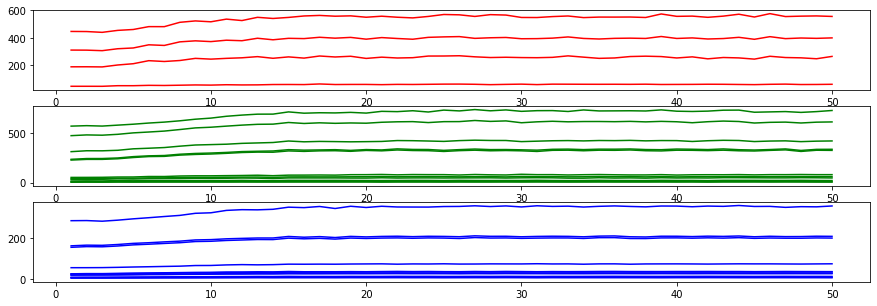

In [22]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Tree/CV_RMSE_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

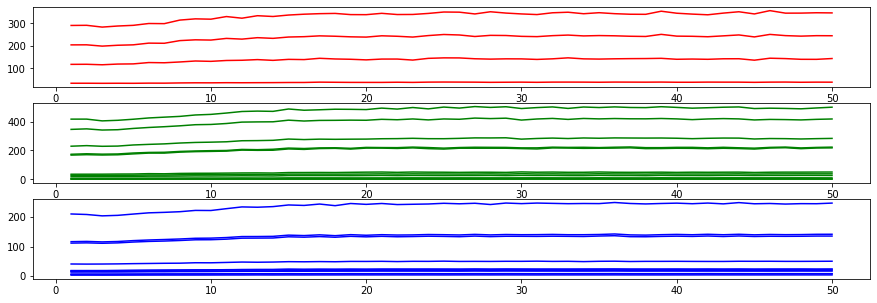

In [23]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Tree/CV_MAE_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

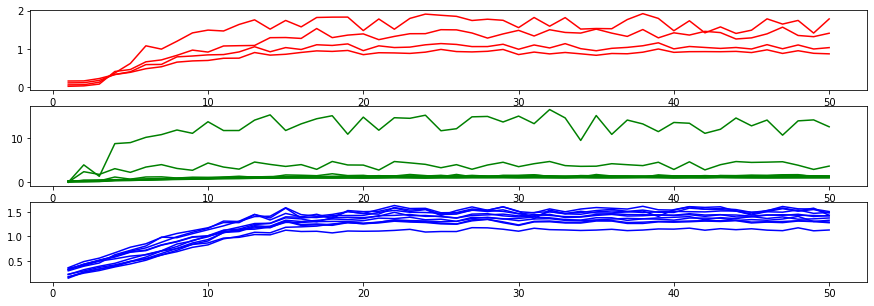

In [24]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Tree/CV_R2_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

## Standard

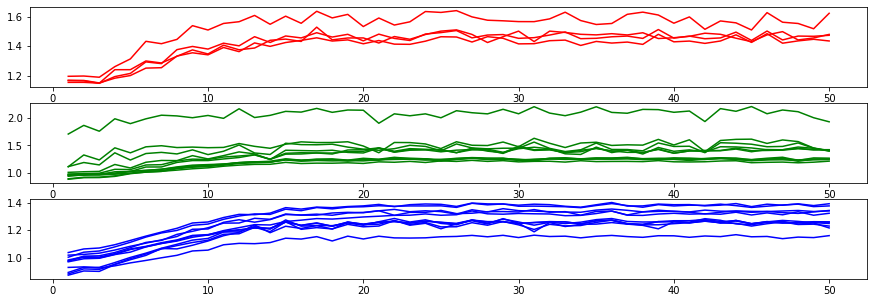

In [26]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Tree/CV_RMSE_standard_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

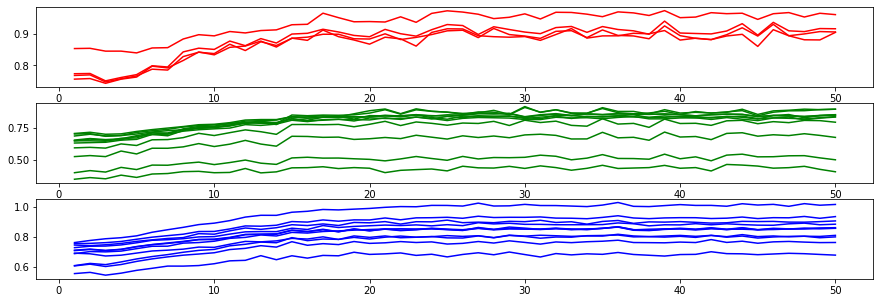

In [28]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Tree/CV_MAE_standard_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

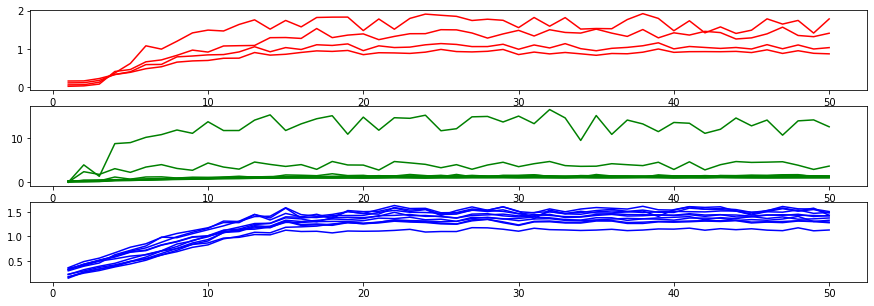

In [30]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Tree/CV_R2_standard_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

## Moyen

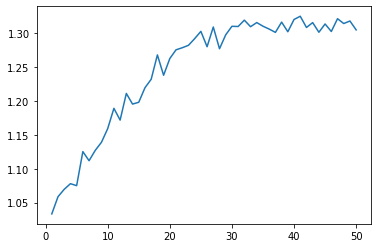

In [8]:
cv_moyen = pd.DataFrame()
for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMTree/CV_RMSE_standard_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["Max_depth"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

In [9]:
cv_moyen[liste_stations_debit].mean(axis = 1).values

array([1.03314679, 1.05859106, 1.06951209, 1.07783647, 1.07493271,
       1.1252489 , 1.11177236, 1.12710958, 1.1390969 , 1.15918669,
       1.18921766, 1.17182171, 1.21122297, 1.19548843, 1.19817392,
       1.21965135, 1.23214191, 1.26815954, 1.23809022, 1.26283323,
       1.27569906, 1.27876106, 1.28234907, 1.29221118, 1.30297859,
       1.2802854 , 1.30942514, 1.27731426, 1.29786423, 1.31047211,
       1.31016298, 1.31956283, 1.30986627, 1.31597414, 1.31058513,
       1.30634941, 1.3014752 , 1.31665814, 1.30238975, 1.32056596,
       1.32533043, 1.30874637, 1.31590263, 1.30168139, 1.31388318,
       1.30278102, 1.32168998, 1.31454157, 1.31830324, 1.30514528])

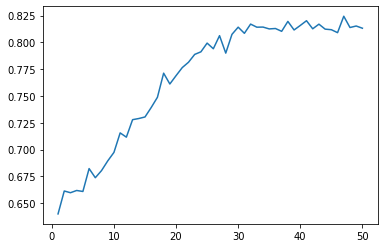

In [10]:
cv_moyen = pd.DataFrame()
for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMTree/CV_MAE_standard_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["Max_depth"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

In [11]:
cv_moyen[liste_stations_debit].mean(axis = 1).values

array([0.63998814, 0.6613655 , 0.65977576, 0.6618565 , 0.66092913,
       0.68228271, 0.6737655 , 0.68041364, 0.68944793, 0.69739926,
       0.71558087, 0.71161277, 0.72791994, 0.7290034 , 0.73045187,
       0.73928516, 0.74881958, 0.77131149, 0.76122629, 0.76900644,
       0.7765327 , 0.78149101, 0.78882869, 0.79123416, 0.79937006,
       0.79410943, 0.80631699, 0.79002703, 0.80753965, 0.81424838,
       0.80851159, 0.81711298, 0.81423061, 0.81432743, 0.81261378,
       0.8129936 , 0.81036706, 0.81961084, 0.81162769, 0.81585267,
       0.82025178, 0.81272785, 0.81704464, 0.81240129, 0.81187384,
       0.80912307, 0.82443613, 0.81391855, 0.81532714, 0.81325654])

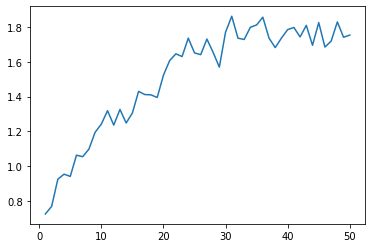

In [12]:
cv_moyen = pd.DataFrame()
for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMTree/CV_R2_standard_depth_" + str(curr_depth) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["Max_depth"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

In [13]:
cv_moyen[liste_stations_debit].mean(axis = 1).values

array([0.72586546, 0.76901504, 0.92529459, 0.9542058 , 0.94139471,
       1.06341412, 1.05458124, 1.09779261, 1.19478729, 1.24178176,
       1.31892416, 1.23614667, 1.32613458, 1.24836175, 1.30540969,
       1.42998469, 1.41172417, 1.40991287, 1.39479088, 1.52301645,
       1.60660514, 1.64565441, 1.63011664, 1.73582336, 1.65112066,
       1.64089806, 1.73045976, 1.65381321, 1.56920491, 1.77030153,
       1.86163387, 1.73549081, 1.72807848, 1.79853362, 1.81156797,
       1.85607291, 1.73589375, 1.68143163, 1.73622647, 1.7846901 ,
       1.79725087, 1.74278234, 1.8093188 , 1.69471136, 1.82518446,
       1.68454465, 1.71877367, 1.82899084, 1.74096869, 1.75342808])

# Test

In [44]:
depth = 5

In [45]:
# Donnees
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

mesures_test_X_standard =fct_Standardize(mesures_test_X, mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
mesures_test_Y_standard = fct_Standardize(mesures_test_Y, mesures_train_X_mean, mesures_train_X_std, 
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
liste_dates = mesures_test_Y["Date"]

In [46]:
# Entrainement
model_tree = DecisionTreeRegressor(max_depth=depth)
model_tree.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
               y = mesures_train_X_standard[liste_stations_debit])

DecisionTreeRegressor(max_depth=5)

In [47]:
# Predictions
predictions_test_Y_standard = model_tree.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values
    # Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [50]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

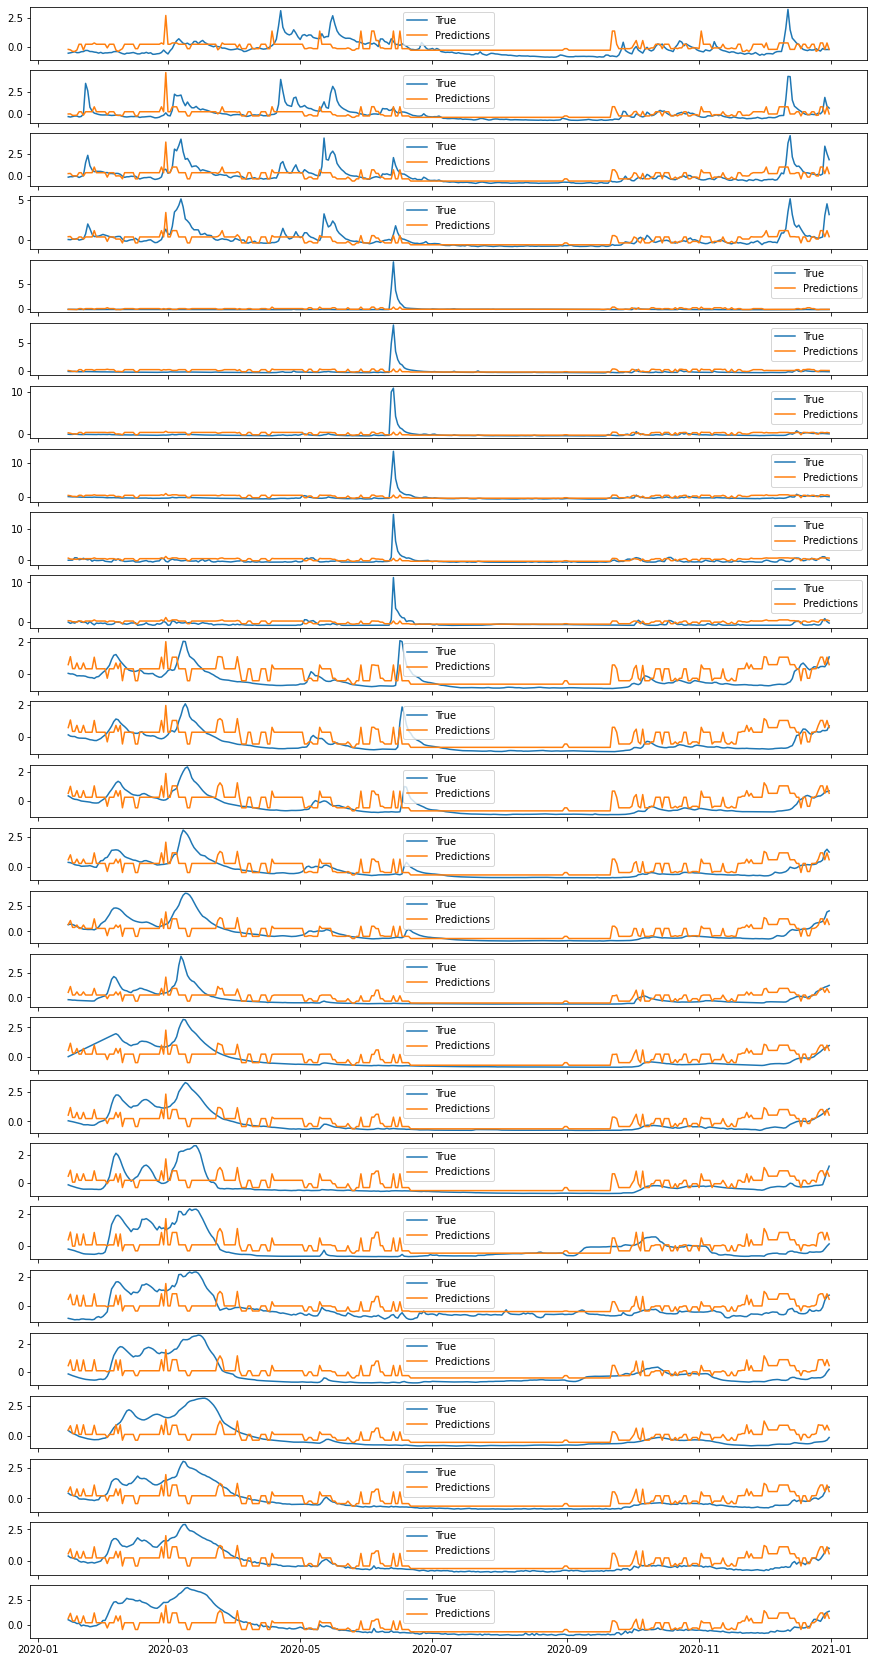

In [51]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

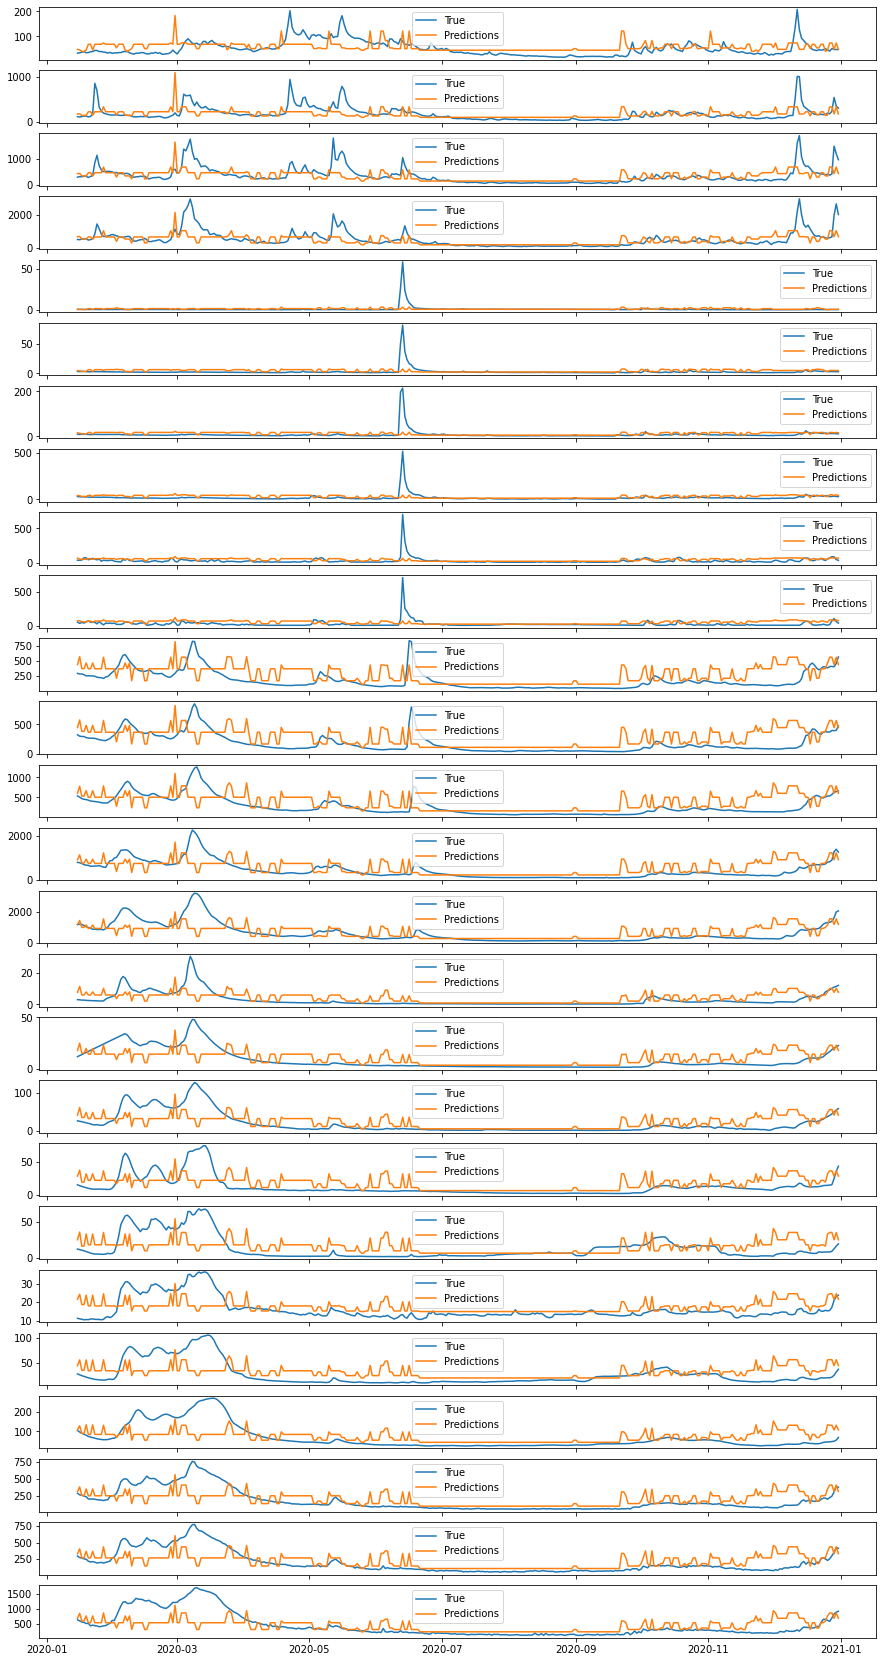

In [52]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y["Date"], mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y["Date"], predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [54]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard.to_csv("../Data/Tree/Test_scores_standard.csv",
                   index = False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.684101,0.521087,0.298601
1,O2620010,0.758051,0.484041,0.297554
2,O6140010,0.816455,0.519068,0.318024
3,O9000010,0.866869,0.526713,0.283327
4,K0030020,0.601081,0.176111,0.033868
5,K0100020,0.645644,0.324629,0.107092
6,K0260020,0.935751,0.436005,0.107283
7,K0550010,1.011242,0.551263,0.163210
8,K0690010,1.080431,0.620507,0.145618
9,K0910050,0.923433,0.597454,0.189025


In [57]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.802628
MAE     0.527530
R2      0.318138
dtype: float64

In [58]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores.to_csv("../Data/Tree/Test_scores.csv",
                   index = False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,31.757082,24.189732,0.298601
1,O2620010,150.256376,95.943678,0.297554
2,O6140010,268.647070,170.794730,0.318024
3,O9000010,421.484711,256.096037,0.283327
4,K0030020,3.686174,1.080015,0.033868
5,K0100020,6.079275,3.056650,0.107092
6,K0260020,17.334312,8.076761,0.107283
7,K0550010,36.842034,20.083876,0.163210
8,K0690010,48.334805,27.759347,0.145618
9,K0910050,53.321305,34.498480,0.189025
